In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)

iteration:,   0, ps_str, 1282.166514
iteration:,   1, ps_str, 148.081582
iteration:,   2, ps_str, 13046.588591
iteration:,   3, ps_str, 148.081582
iteration:,   4, ps_str, 148.081582
iteration:,   5, ps_str, 13041.658073
iteration:,   6, ps_str, 13045.629837
iteration:,   7, ps_str, 13045.472718
iteration:,   8, ps_str, 148.081582
iteration:,   9, ps_str, 13044.150980
iteration:,  10, ps_str, 148.081582
iteration:,  11, ps_str, 148.081582
iteration:,  12, ps_str, 148.081582
iteration:,  13, ps_str, 1282.184428
iteration:,  14, ps_str, 13045.880231
iteration:,  15, ps_str, 148.081582
iteration:,  16, ps_str, 148.081582
iteration:,  17, ps_str, 148.081582
iteration:,  18, ps_str, 13045.868351
iteration:,  19, ps_str, 525.972082
iteration:,  20, ps_str, 1282.153277
iteration:,  21, ps_str, 148.081582
iteration:,  22, ps_str, 13045.247758
iteration:,  23, ps_str, 13042.596322
iteration:,  24, ps_str, 148.081582
iteration:,  25, ps_str, 148.081582
iteration:,  26, ps_str, 1281.946686
iterat

In [2]:
#Nanorod scattering spectrum
#Curvature Constant

import meep as mp
import numpy as np
import matplotlib.pyplot as plt


def get_spectrum_nanorod_cyl(length, wvl_min, wvl_max):

    r = 7.25E-3  # radius of cylinder
    l = length # length of cylinder
    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    frq_min = 1 / wvl_max
    frq_max = 1 / wvl_min
    frq_cen = 0.5 * (frq_min + frq_max)
    dfrq = frq_max - frq_min
    nfrq = 100
    
    resolution = 7/r
    
    dpml = 2*r
    pml_layers = [mp.PML(thickness=dpml)]
    
    symmetries = [mp.Mirror(mp.Y), mp.Mirror(mp.Z, phase=-1)]
    
    s = 2*l + 2*dpml
    cell_size = mp.Vector3(s, s, s)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
        mp.Source(
            mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
            center=mp.Vector3(-0.5*s + dpml),
            size=mp.Vector3(0, s, s),
            component=mp.Ez,
        )
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        default_material = default_material,
        k_point=mp.Vector3(),
        symmetries=symmetries
    )
    
    
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-0.5*l), size=mp.Vector3(0, l, l)),
    )
    
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+0.5*l), size=mp.Vector3(0, l, l)),
    )
    
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= -0.5*l), size=mp.Vector3(l, 0, l)),
    )
    
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= 0.5*l), size=mp.Vector3(l, 0, l)),
    )
    
    box_z1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-0.5*l), size=mp.Vector3(l, l, 0)),
    )
    
    box_z2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+0.5*l), size=mp.Vector3(l, l, 0)),
    )
    
    sim.run(until_after_sources=10)
    
    freqs = mp.get_flux_freqs(box_x1)
    box_x1_data = sim.get_flux_data(box_x1)
    box_x2_data = sim.get_flux_data(box_x2)
    box_y1_data = sim.get_flux_data(box_y1)
    box_y2_data = sim.get_flux_data(box_y2)
    box_z1_data = sim.get_flux_data(box_z1)
    box_z2_data = sim.get_flux_data(box_z2)
    
    box_x1_flux0 = mp.get_fluxes(box_x1)
    
    sim.reset_meep()



    #axis says the orentation of the cylinder
    cylinder = mp.Cylinder(material=Au,
                           radius=r,
                           height=l,
                           center=mp.Vector3(),
                           axis=mp.Vector3(0, 1, 0))
    
    geometry = [cylinder]
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        default_material = default_material,
        k_point=mp.Vector3(),
        symmetries=symmetries,
        geometry=geometry,
    )
    
    
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-0.5*l), size=mp.Vector3(0, l, l)),
    )
    
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+0.5*l), size=mp.Vector3(0, l, l)),
    )
    
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= -0.5*l), size=mp.Vector3(l, 0, l)),
    )
    
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= 0.5*l), size=mp.Vector3(l, 0, l)),
    )
    
    box_z1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-0.5*l), size=mp.Vector3(l, l, 0)),
    )
    
    box_z2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+0.5*l), size=mp.Vector3(l, l, 0)),
    )
    
    
    
    sim.load_minus_flux_data(box_x1, box_x1_data)
    sim.load_minus_flux_data(box_x2, box_x2_data)
    sim.load_minus_flux_data(box_y1, box_y1_data)
    sim.load_minus_flux_data(box_y2, box_y2_data)
    sim.load_minus_flux_data(box_z1, box_z1_data)
    sim.load_minus_flux_data(box_z2, box_z2_data)
    
    sim.run(until_after_sources=100)
    
    #flux power through each flux region.
    box_x1_flux = mp.get_fluxes(box_x1)
    box_x2_flux = mp.get_fluxes(box_x2)
    box_y1_flux = mp.get_fluxes(box_y1)
    box_y2_flux = mp.get_fluxes(box_y2)
    box_z1_flux = mp.get_fluxes(box_z1)
    box_z2_flux = mp.get_fluxes(box_z2)
    
    
    #Just want to plot the power of the scattered flux against wavelength
    scatt_flux = (
        np.asarray(box_x1_flux)
        - np.asarray(box_x2_flux)
        + np.asarray(box_y1_flux)
        - np.asarray(box_y2_flux)
        + np.asarray(box_z1_flux)
        - np.asarray(box_z2_flux)
    )

    return scatt_flux, freqs, l


In [3]:

wvl_min = 400E-3
wvl_max = 1000E-3

freq_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
scatt_data = []
l_labels = []

l_min =10E-3
l_max =35E-3
lengths = np.linspace(l_max,l_min,20)

index = 1

for length in lengths:
    print(f"##################### Run {index} Starting #######################")
    scatt_flux, freqs, length = get_spectrum_nanorod_cyl(length, wvl_min, wvl_max)
    scatt_data.append(scatt_flux)
    freq_data.append(freqs)
    l_labels = np.append(l_labels, length)

    index+=1


##################### Run 1 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00278878 s
Working in 3D dimensions.
Computational cell is 0.0994286 x 0.0994286 x 0.0994286 with resolution 965.517
time for set_epsilon = 0.940098 s
-----------
Meep progress: 0.10357142857142856/16.666666507720947 = 0.6% done in 4.0s, 640.3s to go
on time step 200 (time=0.103571), 0.0200211 s/step
Meep progress: 0.2625535714285714/16.666666507720947 = 1.6% done in 8.0s, 500.5s to go
on time step 507 (time=0.262554), 0.0130491 s/step
Meep progress: 0.43137499999999995/16.666666507720947 = 2.6% done in 12.0s, 452.3s to go
on time step 833 (time=0.431375), 0.0122867 s/step
Meep progress: 0.5515178571428571/16.666666507720947 = 3.3% done in 16.0s, 468.0s to go
on time step 1066 (time=0.552036), 0.0172377 s/step
Meep progress: 0.6783928571428571/16.666666507720947 = 4.

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00242305 s
Working in 3D dimensions.
Computational cell is 0.0994286 x 0.0994286 x 0.0994286 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.035, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.763426 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.041946428571428565/106.66666650772095 = 0.0% done in 4.0s, 10181.9s to go
on time step 81 (time=0.0419464), 0.0494541 s/step
Meep progress: 0.14707142857142858/106.66666650772095 = 0.1% done in 8.0s, 5805.9s to go
on time step 284 (time=0.147071), 0.0197519 s/step
Meep progress: 0.2589285714285714/106.66666650772095 = 0.2% 

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00386286 s
Working in 3D dimensions.
Computational cell is 0.0963214 x 0.0963214 x 0.0963214 with resolution 965.517
time for set_epsilon = 0.611256 s
-----------
Meep progress: 0.14551785714285714/16.666666507720947 = 0.9% done in 4.0s, 454.2s to go
on time step 281 (time=0.145518), 0.0142369 s/step
Meep progress: 0.3485178571428571/16.666666507720947 = 2.1% done in 8.0s, 374.8s to go
on time step 673 (time=0.348518), 0.0102119 s/step
Meep progress: 0.5525535714285714/16.666666507720947 = 3.3% done in 12.0s, 350.2s to go
on time step 1067 (time=0.552554), 0.0101621 s/step
Meep progress: 0.7488214285714285/16.666666507720947 = 

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00542784 s
Working in 3D dimensions.
Computational cell is 0.0963214 x 0.0963214 x 0.0963214 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0336842, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.621107 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.07819642857142857/106.66666650772095 = 0.1% done in 4.0s, 5457.8s to go
on time step 151 (time=0.0781964), 0.0265182 s/step
Meep progress: 0.20507142857142857/106.66666650772095 = 0.2% done in 8.0s, 4155.7s to go
on time step 397 (time=0.2

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00440598 s
Working in 3D dimensions.
Computational cell is 0.09425 x 0.09425 x 0.09425 with resolution 965.517
time for set_epsilon = 0.655927 s
-----------
Meep progress: 0.14344642857142856/16.666666507720947 = 0.9% done in 4.0s, 461.9s to go
on time step 277 (time=0.143446), 0.0144766 s/step
Meep progress: 0.34178571428571425/16.666666507720947 = 2.1% done in 8.0s, 382.9s to go
on time step 660 (time=0.341786), 0.0104585 s/step
Meep progress: 0.5768928571428571/16.666666507720947 = 3.5% done in 12.0s, 335.2s to go
on time step 1114 (time=0.576893), 0.00881156 s/step
Meep progress: 0.7990535714285714/16.666666507720947 = 4.8%

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00333095 s
Working in 3D dimensions.
Computational cell is 0.09425 x 0.09425 x 0.09425 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0323684, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.608343 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.11030357142857142/106.66666650772095 = 0.1% done in 4.0s, 3873.3s to go
on time step 213 (time=0.110304), 0.0188246 s/step
Meep progress: 0.2672142857142857/106.66666650772095 = 0.3% done in 8.0s, 3191.5s to go
on time step 516 (time=0.267214), 

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.0021081 s
Working in 3D dimensions.
Computational cell is 0.0911429 x 0.0911429 x 0.0911429 with resolution 965.517
time for set_epsilon = 0.673074 s
-----------
Meep progress: 0.15069642857142856/16.666666507720947 = 0.9% done in 4.0s, 439.0s to go
on time step 291 (time=0.150696), 0.0137656 s/step
Meep progress: 0.36923214285714284/16.666666507720947 = 2.2% done in 8.0s, 353.4s to go
on time step 714 (time=0.36975), 0.00947556 s/step
Meep progress: 0.5944999999999999/16.666666507720947 = 3.6% done in 12.0s, 324.9s to go
on time step 1148 (time=0.5945), 0.00921874 s/step
Meep progress: 0.8208035714285714/16.666666507720947 = 4.9% done in 16.0s, 309.3s to go
on time step 1585 (time=0.820804), 0.00916409 s/st

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00199199 s
Working in 3D dimensions.
Computational cell is 0.0911429 x 0.0911429 x 0.0911429 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0310526, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.552154 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.08803571428571427/106.66666650772095 = 0.1% done in 4.0s, 4850.1s to go
on time step 170 (time=0.0880357), 0.0235673 s/step
Meep progress: 0.23044642857142855/106.66666650772095 = 0.2% done in 8.0s, 3699.1s to go
on time step 445 (time=0.230446), 0.0145534 s/step
Meep progress: 0.3630178571428571/106.66666650772095 = 0.

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00391698 s
Working in 3D dimensions.
Computational cell is 0.0880357 x 0.0880357 x 0.0880357 with resolution 965.517
time for set_epsilon = 0.526638 s
-----------
Meep progress: 0.16623214285714286/16.666666507720947 = 1.0% done in 4.0s, 397.4s to go
on time step 321 (time=0.166232), 0.0124734 s/step
Meep progress: 0.41428571428571426/16.666666507720947 = 2.5% done in 8.0s, 314.2s to go
on time step 800 (time=0.414286), 0.00835958 s/step
Meep progress: 0.6468035714285714/16.666666507720947 = 3.9% done in 12.0s, 297.7s to go
on time step 1249 (time=0.646804), 0.00892701 s/step
Meep progress: 0.8989999999999999/16.666666507720947

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00361609 s
Working in 3D dimensions.
Computational cell is 0.0880357 x 0.0880357 x 0.0880357 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0297368, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.393631 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.11237499999999999/106.66666650772095 = 0.1% done in 4.0s, 3795.6s to go
on time step 217 (time=0.112375), 0.0184478 s/step
Meep progress: 0.26151785714285714/106.66666650772095 = 0.2% done in 8.0s, 3263.4s to go
on time step 505 (time=0.26

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 6 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00412583 s
Working in 3D dimensions.
Computational cell is 0.0859643 x 0.0859643 x 0.0859643 with resolution 965.517
time for set_epsilon = 0.517936 s
-----------
Meep progress: 0.16985714285714285/16.666666507720947 = 1.0% done in 4.0s, 388.6s to go
on time step 328 (time=0.169857), 0.0121992 s/step
Meep progress: 0.4194642857142857/16.666666507720947 = 2.5% done in 8.0s, 310.0s to go
on time step 810 (time=0.419464), 0.00830327 s/step
Meep progress: 0.677875/16.666666507720947 = 4.1% done in 12.0s, 283.2s to go
on time step 1309 (time=0.677875), 0.00801672 s/step
Meep progress: 0.9305892857142857/16.666666507720947 = 5.6% don

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00405002 s
Working in 3D dimensions.
Computational cell is 0.0859643 x 0.0859643 x 0.0859643 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0284211, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.61718 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.10667857142857143/106.66666650772095 = 0.1% done in 4.0s, 4005.2s to go
on time step 206 (time=0.106679), 0.0194653 s/step
Meep progress: 0.26566071428571425/106.66666650772095 = 0.2% done in 8.0s, 3211.8s to go
on time step 513 (time=0.265

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 7 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00192904 s
Working in 3D dimensions.
Computational cell is 0.0828571 x 0.0828571 x 0.0828571 with resolution 965.517
time for set_epsilon = 0.293582 s
-----------
Meep progress: 0.29932142857142857/16.666666507720947 = 1.8% done in 4.0s, 218.8s to go
on time step 578 (time=0.299321), 0.00692202 s/step
Meep progress: 0.6468035714285714/16.666666507720947 = 3.9% done in 8.0s, 198.3s to go
on time step 1249 (time=0.646804), 0.0059673 s/step
Meep progress: 0.9906607142857142/16.666666507720947 = 5.9% done in 12.0s, 190.1s to go
on time step 1913 (time=0.990661), 0.00603489 s/step
Meep progress: 1.3479821428571428/16.666666507720947 = 8.1% done in 16.0s, 182.0s to go
on time step 2603 (time=1.34798), 0.00580004 s

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00162411 s
Working in 3D dimensions.
Computational cell is 0.0828571 x 0.0828571 x 0.0828571 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0271053, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.346813 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.16882142857142857/106.66666650772095 = 0.2% done in 4.0s, 2529.5s to go
on time step 326 (time=0.168821), 0.0123005 s/step
Meep progress: 0.3966785714285714/106.66666650772095 = 0.4% done in 8.0s, 2147.6s to go
on time step 766 (time=0.396679), 0.00910324 s/step
Meep progress: 0.6369642857142856/106.66666650772095 = 0.6

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 8 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00193787 s
Working in 3D dimensions.
Computational cell is 0.0807857 x 0.0807857 x 0.0807857 with resolution 965.517
time for set_epsilon = 0.285654 s
-----------
Meep progress: 0.322625/16.666666507720947 = 1.9% done in 4.0s, 202.7s to go
on time step 623 (time=0.322625), 0.00642169 s/step
Meep progress: 0.7125714285714285/16.666666507720947 = 4.3% done in 8.0s, 179.2s to go
on time step 1376 (time=0.712571), 0.00531683 s/step
Meep progress: 1.113392857142857/16.666666507720947 = 6.7% done in 12.0s, 167.7s to go
on time step 2150 (time=1.11339), 0.00517082 s/step
Meep progress: 1.5452857142857142/16.666666507720947 = 9.3% done in 16.0s, 156.7s to go
on time step 2984 (time=1.54529), 0.00479708 s/step
Meep p

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00173593 s
Working in 3D dimensions.
Computational cell is 0.0807857 x 0.0807857 x 0.0807857 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0257895, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.387325 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.1983392857142857/106.66666650772095 = 0.2% done in 4.0s, 2148.8s to go
on time step 383 (time=0.198339), 0.0104523 s/step
Meep progress: 0.4520892857142857/106.66666650772095 = 0.4% done in 8.0s, 1880.4s to go
on time step 874 (time=0.452607), 0.00816278 s/step
Meep progress: 0.7089464285714285/106.66666650772095 = 0.7%

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 9 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00293779 s
Working in 3D dimensions.
Computational cell is 0.0776786 x 0.0776786 x 0.0776786 with resolution 965.517
time for set_epsilon = 0.311959 s
-----------
Meep progress: 0.34696428571428567/16.666666507720947 = 2.1% done in 4.0s, 188.2s to go
on time step 670 (time=0.346964), 0.00597244 s/step
Meep progress: 0.8213214285714285/16.666666507720947 = 4.9% done in 8.0s, 154.4s to go
on time step 1587 (time=0.821839), 0.00437012 s/step
Meep progress: 1.2558035714285714/16.666666507720947 = 7.5% done in 12.0s, 147.3s to go
on time step 2426 (time=1.25632), 0.00476863 s/step
Meep progress: 1.7073749999999999/16.666666507720947

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00332904 s
Working in 3D dimensions.
Computational cell is 0.0776786 x 0.0776786 x 0.0776786 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0244737, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.318144 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.20662499999999998/106.66666650772095 = 0.2% done in 4.0s, 2065.6s to go
on time step 399 (time=0.206625), 0.0100482 s/step
Meep progress: 0.48160714285714284/106.66666650772095 = 0.5% done in 8.0s, 1767.1s to go
on time step 930 (time=0.48

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00243115 s
Working in 3D dimensions.
Computational cell is 0.0756071 x 0.0756071 x 0.0756071 with resolution 965.517
time for set_epsilon = 0.242389 s
-----------
Meep progress: 0.3723392857142857/16.666666507720947 = 2.2% done in 4.0s, 175.1s to go
on time step 719 (time=0.372339), 0.00556651 s/step
Meep progress: 0.8021607142857142/16.666666507720947 = 4.8% done in 8.0s, 158.3s to go
on time step 1550 (time=0.802679), 0.00481843 s/step
Meep progress: 1.2413035714285714/16.666666507720947 = 7.4% done in 12.0s, 149.2s to go
on time step 2398 (time=1.24182), 0.00472121 s/step
Meep progress: 1.6561071428571428/16.666666507720947

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.002455 s
Working in 3D dimensions.
Computational cell is 0.0756071 x 0.0756071 x 0.0756071 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0231579, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.294013 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.2263035714285714/106.66666650772095 = 0.2% done in 4.0s, 1884.0s to go
on time step 437 (time=0.226304), 0.00916652 s/step
Meep progress: 0.5354642857142857/106.66666650772095 = 0.5% done in 8.0s, 1587.1s to go
on time step 1034 (time=0.5354

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00149488 s
Working in 3D dimensions.
Computational cell is 0.0725 x 0.0725 x 0.0725 with resolution 965.517
time for set_epsilon = 0.193766 s
-----------
Meep progress: 0.41894642857142855/16.666666507720947 = 2.5% done in 4.0s, 155.3s to go
on time step 809 (time=0.418946), 0.00495112 s/step
Meep progress: 0.9145357142857142/16.666666507720947 = 5.5% done in 8.0s, 137.9s to go
on time step 1766 (time=0.914536), 0.00418051 s/step
Meep progress: 1.3909642857142857/16.666666507720947 = 8.3% done in 12.0s, 131.9s to go
on time step 2686 (time=1.39096), 0.00435034 s/step
Meep progress: 1.9486964285714283/16.666666507720947 = 11.7% done in 16.0s, 120.9s to go
on time step 3763 (time=1.9487), 0.00371561 s/step
Me

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00173688 s
Working in 3D dimensions.
Computational cell is 0.0725 x 0.0725 x 0.0725 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0218421, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.246879 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.261/106.66666650772095 = 0.2% done in 4.0s, 1633.0s to go
on time step 504 (time=0.261), 0.00794781 s/step
Meep progress: 0.6012321428571428/106.66666650772095 = 0.6% done in 8.0s, 1412.5s to go
on time step 1161 (time=0.601232), 0.00608954 s/step
Meep progress: 0.9342142857142857/106.66666650772095 = 0.9% done in 12.0s, 1359.3s

Meep progress: 106.65889285714285/106.66666650772095 = 100.0% done in 1269.0s, 0.1s to go
run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00184703 s
Working in 3D dimensions.
Computational cell is 0.0704286 x 0.0704286 x 0.0704286 with resolution 965.517
time for set_epsilon = 0.229277 s
-----------
Meep progress: 0.45312499999999994/16.666666507720947 = 2.7% done in 4.0s, 143.2s to go
on time step 875 (time=0.453125), 0.00457345 s/step
Meep progress: 1.0139642857142857/16.666666507720947 = 6.1% done in 8.0s, 123.6s to go
on time step 1958 (time=1.01396), 0.00369663 s/step
Meep progress: 1.6296964285714284/16.666666507720947 = 9.8% done in 12.0s, 110.8s to go
on time step 3147 (time=1.6297), 0.00336425 s/step
Meep progress: 2.171375/16.666666507720947 = 

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00150394 s
Working in 3D dimensions.
Computational cell is 0.0704286 x 0.0704286 x 0.0704286 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0205263, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.271011 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.28275/106.66666650772095 = 0.3% done in 4.0s, 1506.5s to go
on time step 546 (time=0.28275), 0.00733356 s/step
Meep progress: 0.6354107142857143/106.66666650772095 = 0.6% done in 8.0s, 1336.2s to go
on time step 1227 (time=0.635411), 0.00587718 s/step
Meep progress: 0.986/106.66666650772095 = 0.9% done in 12.0s, 1287.3s

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 13 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00258708 s
Working in 3D dimensions.
Computational cell is 0.0673214 x 0.0673214 x 0.0673214 with resolution 965.517
time for set_epsilon = 0.121326 s
-----------
Meep progress: 0.6623392857142857/16.666666507720947 = 4.0% done in 4.0s, 96.7s to go
on time step 1279 (time=0.662339), 0.00312757 s/step
Meep progress: 1.2967142857142857/16.666666507720947 = 7.8% done in 8.0s, 94.8s to go
on time step 2504 (time=1.29671), 0.00326597 s/step
Meep progress: 1.8575535714285714/16.666666507720947 = 11.1% done in 12.0s, 95.7s to go
on time step 3587 (time=1.85755), 0.00369599 s/step
Meep progress: 2.480017857142857/16.666666507720947 = 

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00201106 s
Working in 3D dimensions.
Computational cell is 0.0673214 x 0.0673214 x 0.0673214 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0192105, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.158142 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.3568035714285714/106.66666650772095 = 0.3% done in 4.0s, 1192.0s to go
on time step 689 (time=0.356804), 0.00580664 s/step
Meep progress: 0.7467499999999999/106.66666650772095 = 0.7% done in 8.0s, 1135.4s to go
on time step 1442 (time=0.74

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 14 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00426793 s
Working in 3D dimensions.
Computational cell is 0.06525 x 0.06525 x 0.06525 with resolution 965.517
time for set_epsilon = 0.140344 s
-----------
Meep progress: 0.5919107142857143/16.666666507720947 = 3.6% done in 4.0s, 108.7s to go
on time step 1143 (time=0.591911), 0.00350237 s/step
Meep progress: 1.2511428571428571/16.666666507720947 = 7.5% done in 8.0s, 98.6s to go
on time step 2417 (time=1.25166), 0.0031433 s/step
Meep progress: 1.9124464285714284/16.666666507720947 = 11.5% done in 12.0s, 92.6s to go
on time step 3695 (time=1.91348), 0.00313194 s/step
Meep progress: 2.6265714285714283/16.666666507720947 = 15.8%

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00223613 s
Working in 3D dimensions.
Computational cell is 0.06525 x 0.06525 x 0.06525 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0178947, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.157768 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.3505892857142857/106.66666650772095 = 0.3% done in 4.0s, 1214.1s to go
on time step 677 (time=0.350589), 0.00591399 s/step
Meep progress: 0.772125/106.66666650772095 = 0.7% done in 8.0s, 1097.8s to go
on time step 1492 (time=0.772643), 0.0049124

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00124002 s
Working in 3D dimensions.
Computational cell is 0.0621429 x 0.0621429 x 0.0621429 with resolution 965.517
time for set_epsilon = 0.118015 s
-----------
Meep progress: 0.8280535714285714/16.666666507720947 = 5.0% done in 4.0s, 76.5s to go
on time step 1599 (time=0.828054), 0.00250238 s/step
Meep progress: 1.5908571428571427/16.666666507720947 = 9.5% done in 8.0s, 75.8s to go
on time step 3072 (time=1.59086), 0.00271635 s/step
Meep progress: 2.365571428571428/16.666666507720947 = 14.2% done in 12.0s, 72.6s to go
on time step 4568 (time=2.36557), 0.00267452 s/step
Meep progress: 3.119571428571428/16.666666507720947 = 18.7% done in 16.0s, 69.5s to go
on time step 6024 (time=3.11957), 0.0027481 s/step

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00143409 s
Working in 3D dimensions.
Computational cell is 0.0621429 x 0.0621429 x 0.0621429 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0165789, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.175345 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.41842857142857137/106.66666650772095 = 0.4% done in 4.0s, 1015.7s to go
on time step 808 (time=0.418429), 0.00495098 s/step
Meep progress: 0.903142857142857/106.66666650772095 = 0.8% done in 8.0s, 937.0s to go
on time step 1744 (time=0.903143), 0.00427405 s/step
Meep progress: 1.3578214285714285/106.66666650772095 = 1.3

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 16 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00362802 s
Working in 3D dimensions.
Computational cell is 0.0590357 x 0.0590357 x 0.0590357 with resolution 965.517
time for set_epsilon = 0.162897 s
-----------
Meep progress: 0.7415714285714285/16.666666507720947 = 4.4% done in 4.0s, 85.9s to go
on time step 1432 (time=0.741571), 0.0027939 s/step
Meep progress: 1.5028214285714285/16.666666507720947 = 9.0% done in 8.0s, 80.7s to go
on time step 2903 (time=1.50334), 0.0027206 s/step
Meep progress: 2.292035714285714/16.666666507720947 = 13.8% done in 12.0s, 75.3s to go
on time step 4427 (time=2.29255), 0.00262581 s/step
Meep progress: 3.0916071428571428/16.666666507720947 = 18

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.0029912 s
Working in 3D dimensions.
Computational cell is 0.0590357 x 0.0590357 x 0.0590357 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0152632, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.175411 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.4696964285714285/106.66666650772095 = 0.4% done in 4.0s, 904.5s to go
on time step 907 (time=0.469696), 0.00441088 s/step
Meep progress: 0.9854821428571428/106.66666650772095 = 0.9% done in 8.0s, 858.2s to go
on time step 1903 (time=0.98548

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 17 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00312209 s
Working in 3D dimensions.
Computational cell is 0.0569643 x 0.0569643 x 0.0569643 with resolution 965.517
time for set_epsilon = 0.107659 s
-----------
Meep progress: 0.7990535714285714/16.666666507720947 = 4.8% done in 4.0s, 79.4s to go
on time step 1543 (time=0.799054), 0.00259287 s/step
Meep progress: 1.6959821428571427/16.666666507720947 = 10.2% done in 8.0s, 70.6s to go
on time step 3276 (time=1.6965), 0.00230936 s/step
Meep progress: 2.614142857142857/16.666666507720947 = 15.7% done in 12.0s, 64.5s to go
on time step 5049 (time=2.61466), 0.00225624 s/step
Meep progress: 3.487767857142857/16.666666507720947 = 2

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00269008 s
Working in 3D dimensions.
Computational cell is 0.0569643 x 0.0569643 x 0.0569643 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0139474, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.149499 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.4790178571428571/106.66666650772095 = 0.4% done in 4.0s, 887.8s to go
on time step 925 (time=0.479018), 0.00432968 s/step
Meep progress: 1.0191428571428571/106.66666650772095 = 1.0% done in 8.0s, 830.1s to go
on time step 1968 (time=1.0191

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.0018518 s
Working in 3D dimensions.
Computational cell is 0.0538571 x 0.0538571 x 0.0538571 with resolution 965.517
time for set_epsilon = 0.091249 s
-----------
Meep progress: 0.9642499999999999/16.666666507720947 = 5.8% done in 4.0s, 65.2s to go
on time step 1862 (time=0.96425), 0.00214883 s/step
Meep progress: 1.9347142857142856/16.666666507720947 = 11.6% done in 8.0s, 60.9s to go
on time step 3736 (time=1.93471), 0.00213596 s/step
Meep progress: 2.9719821428571427/16.666666507720947 = 17.8% done in 12.0s, 55.3s to go
on time step 5739 (time=2.97198), 0.00199735 s/step
Meep progress: 3.9424464285714285/16.666666507720947 = 23.7% done in 16.0s, 51.7s to go
on time step 7613 (time=3.94245), 0.00213468 s/st

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00159216 s
Working in 3D dimensions.
Computational cell is 0.0538571 x 0.0538571 x 0.0538571 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0126316, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.103341 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.7151607142857143/106.66666650772095 = 0.7% done in 4.0s, 592.8s to go
on time step 1381 (time=0.715161), 0.00289746 s/step
Meep progress: 1.5256071428571427/106.66666650772095 = 1.4% done in 8.0s, 551.5s to go
on time step 2946 (time=1.52561), 0.00255661 s/step
Meep progress: 2.2998035714285714/106.66666650772095 = 2.2%

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 19 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00212789 s
Working in 3D dimensions.
Computational cell is 0.0517857 x 0.0517857 x 0.0517857 with resolution 965.517
time for set_epsilon = 0.087399 s
-----------
Meep progress: 0.9492321428571427/16.666666507720947 = 5.7% done in 4.0s, 66.3s to go
on time step 1833 (time=0.949232), 0.00218318 s/step
Meep progress: 1.9393749999999998/16.666666507720947 = 11.6% done in 8.0s, 60.8s to go
on time step 3745 (time=1.93937), 0.00209213 s/step
Meep progress: 2.9414285714285713/16.666666507720947 = 17.6% done in 12.0s, 56.0s to go
on time step 5680 (time=2.94143), 0.00206732 s/step
Meep progress: 3.9647142857142854/16.666666507720947 = 23.8% done in 16.0s, 51.3s to go
on time step 7656 (time=3.96471), 0.00202432 s/

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00309396 s
Working in 3D dimensions.
Computational cell is 0.0517857 x 0.0517857 x 0.0517857 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0113158, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.153376 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.6038214285714285/106.66666650772095 = 0.6% done in 4.0s, 702.9s to go
on time step 1166 (time=0.603821), 0.00343234 s/step
Meep progress: 1.2884285714285713/106.66666650772095 = 1.2% done in 8.0s, 654.6s to go
on time step 2488 (time=1.28843), 0.00302651 s/step
Meep progress: 2.0056607142857144/106.66666650772095 = 1.9%

run 0 finished at t = 106.66717857142856 (205978 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00270796 s
Working in 3D dimensions.
Computational cell is 0.0486786 x 0.0486786 x 0.0486786 with resolution 965.517
time for set_epsilon = 0.0624039 s
-----------
Meep progress: 1.3438392857142856/16.666666507720947 = 8.1% done in 4.0s, 45.6s to go
on time step 2595 (time=1.34384), 0.00154178 s/step
Meep progress: 2.788142857142857/16.666666507720947 = 16.7% done in 8.0s, 39.8s to go
on time step 5384 (time=2.78814), 0.00143423 s/step
Meep progress: 4.112821428571428/16.666666507720947 = 24.7% done in 12.0s, 36.6s to go
on time step 7942 (time=4.11282), 0.00156417 s/step
Meep progress: 5.4587321428571425/16.666666507720947 = 

run 0 finished at t = 16.666714285714285 (32184 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00263691 s
Working in 3D dimensions.
Computational cell is 0.0486786 x 0.0486786 x 0.0486786 with resolution 965.517
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.01, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.0938449 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.6954821428571428/106.66666650772095 = 0.7% done in 4.0s, 609.7s to go
on time step 1343 (time=0.695482), 0.00297957 s/step
Meep progress: 1.58775/106.66666650772095 = 1.5% done in 8.0s, 529.6s to go
on time step 3066 (time=1.58775), 0.00232184

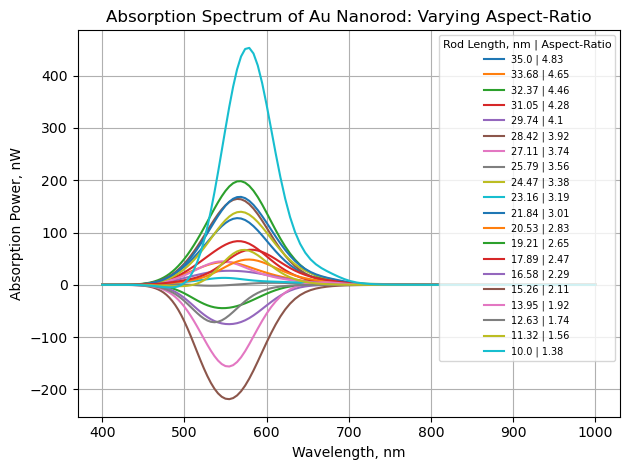

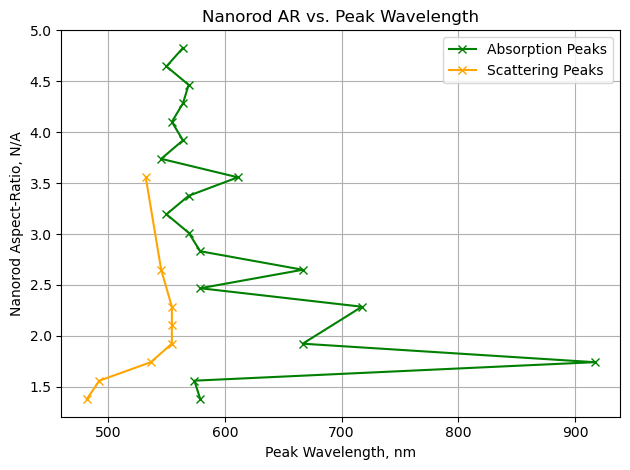

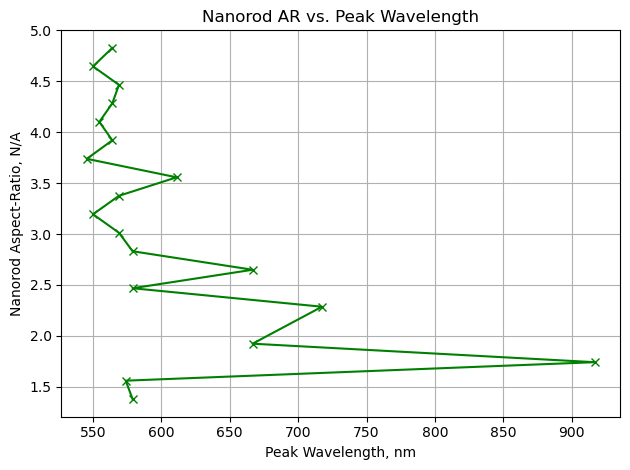

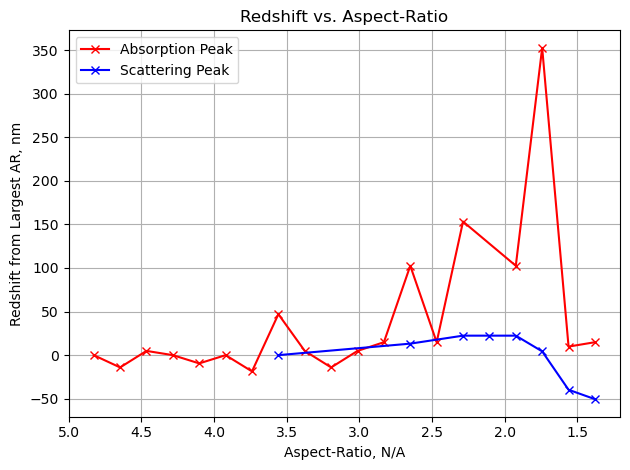

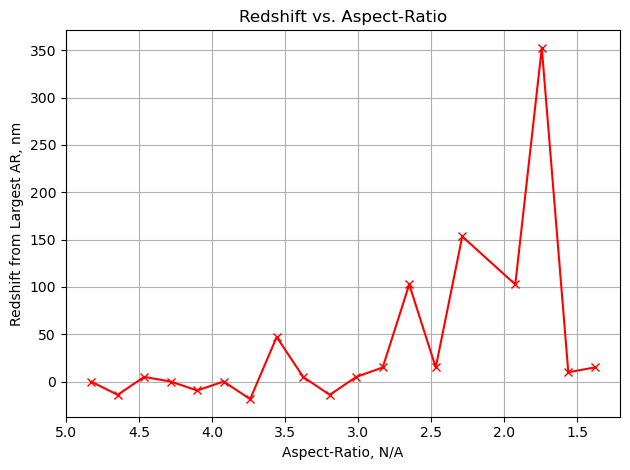

In [16]:
max_wvls_ab = [] #to store the wavelength value where the peak occurs
max_wvls_sc = []
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.
#
plt.figure()
for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    length = lengths[index]
    AR = float(length)/(7.25E-3)
    
    plt.plot(1E3/freqs, -1*scatt_flux*1E9, "-", label=f"{str(1E3*round(float(length),5))[:5]} | {round(AR,2)}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, nW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly
    plt.legend(loc="upper right", title = "Rod Length, nm | Aspect-Ratio", fontsize = 7, title_fontsize= 8)
    plt.title("Absorption Spectrum of Au Nanorod: Varying Aspect-Ratio")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    
    max_wvl_ab = 1E3/freqs[np.argmin(scatt_flux)]
    
    max_wvl_sc = 1E3/freqs[np.argmax(scatt_flux)]
    
    max_wvls_ab.append([length, max_wvl_ab])
    max_wvls_sc.append([length, max_wvl_sc])

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="Absorption Spectrum of Au Nanorod: Varying Aspect-Ratio",
            dpi=150, 
            bbox_inches="tight")

max_wvls_ab = np.asarray(max_wvls_ab)
max_wvls_sc = np.asarray(max_wvls_sc)



#plot curvature vs. peak position

#excluding non-value elements
max_wvls_ab = np.delete(max_wvls_ab, 15, axis=0)
max_wvls_sc = np.delete(max_wvls_sc, [0,1,2,3,4,5,6,8,9,10,11,13], axis=0)

plt.figure()
plt.plot(max_wvls_ab[:,1], max_wvls_ab[:,0]/(7.25E-3), "gx-", label="Absorption Peaks")
plt.plot(max_wvls_sc[:,1], max_wvls_sc[:,0]/(7.25E-3), "x-",c="orange", label="Scattering Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanorod Aspect-Ratio, N/A")
plt.title("Nanorod AR vs. Peak Wavelength")
plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig(fname="Nanorod AR vs Peak Wavelength, both peaks",
            dpi=150, 
            bbox_inches="tight")

plt.figure()
plt.plot(max_wvls_ab[:,1], max_wvls_ab[:,0]/(7.25E-3), "gx-")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanorod Aspect-Ratio, N/A")
plt.title("Nanorod AR vs. Peak Wavelength")
plt.tight_layout()
plt.savefig(fname="Nanorod AR vs Peak Wavelength, one peak",
            dpi=150, 
            bbox_inches="tight")


#Plot of redshift vs. AR

AR_ab = max_wvls_ab[:,0]/(7.25E-3) #AR=length/width
AR_sc = max_wvls_sc[:,0]/(7.25E-3)
redshift_ab = max_wvls_ab[:,1]-max_wvls_ab[0,1] #peak position minus longest cylinder position
redshift_sc = max_wvls_sc[:,1]-max_wvls_sc[0,1]

plt.figure()
plt.plot(AR_ab, redshift_ab, "rx-", label="Absorption Peak")
plt.plot(AR_sc, redshift_sc, "bx-", label="Scattering Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Aspect-Ratio, N/A")
plt.ylabel("Redshift from Largest AR, nm")
plt.title("Redshift vs. Aspect-Ratio")
plt.tight_layout()
plt.legend(loc="upper left")
plt.savefig(fname="Redshift vs Aspect-Ratio, both peaks",
            dpi=150, 
            bbox_inches="tight")

plt.figure()
plt.plot(AR_ab, redshift_ab, "rx-")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Aspect-Ratio, N/A")
plt.ylabel("Redshift from Largest AR, nm")
plt.title("Redshift vs. Aspect-Ratio")
plt.tight_layout()
plt.savefig(fname="Redshift vs Aspect-Ratio, one peaks",
            dpi=150, 
            bbox_inches="tight")



In [ ]:
### single nanorod, to hopefully see second peak.

wvl_min = 400E-3
wvl_max = 1000E-3

length = 29E-3
AR = length/(7.25E-3)
scatt_flux, freqs, rubbish = get_spectrum_nanorod_cyl(length, wvl_min, wvl_max)




In [ ]:
freqs = np.asarray(freqs)

plt.plot(1E3/freqs, -1*scatt_flux*1E9, "-")
plt.grid(True, which="both", ls="-")
plt.xlabel("Wavelength, nm")
plt.ylabel("Absorption Power, nW")
plt.title(f"Absorption Spectrum of Au Nanorod: Aspect-Ratio = {round(AR,2)}")
plt.tight_layout()

plt.savefig(fname="Absorption Spectrum of Au Nanorod: Varying Aspect-Ratio",
            dpi=150, 
            bbox_inches="tight")

print(1E3/freqs[np.argmax(-1*scatt_flux*1E9)])